In [1]:
# Collecting the data of Sensex from yahoo finance.

import time
import datetime
import pandas as pd

tickers = ['^BSESN']
interval = '1d'
period1 = int(time.mktime(datetime.datetime(1997, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 2, 18, 23, 59).timetuple()))

for ticker in tickers:
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df = pd.read_csv(query_string)
    df.to_csv('sensex_data1.csv', index = None, header = True)

df_prices = pd.read_csv('sensex_data1.csv')
print(df_prices.head())
print(df_prices.size)

df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

         Date         Open         High          Low        Close  \
0  1997-07-01  4263.109863  4301.770020  4247.660156  4300.859863   
1  1997-07-02  4302.959961  4395.310059  4295.399902  4333.899902   
2  1997-07-03  4335.790039  4393.290039  4299.970215  4323.459961   
3  1997-07-04  4332.700195  4347.589844  4300.580078  4323.819824   
4  1997-07-07  4326.810059  4391.009766  4289.490234  4291.450195   

     Adj Close  Volume  
0  4300.859863     0.0  
1  4333.899902     0.0  
2  4323.459961     0.0  
3  4323.819824     0.0  
4  4291.450195     0.0  
43365
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6195 entries, 0 to 6194
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6195 non-null   datetime64[ns]
 1   Open       6070 non-null   float64       
 2   High       6070 non-null   float64       
 3   Low        6070 non-null   float64       
 4   Close      6070 non-null   float64  

In [2]:
# importing the other required libraries and modules.

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm
from pmdarima import auto_arima

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Text(0, 0.5, 'Close')

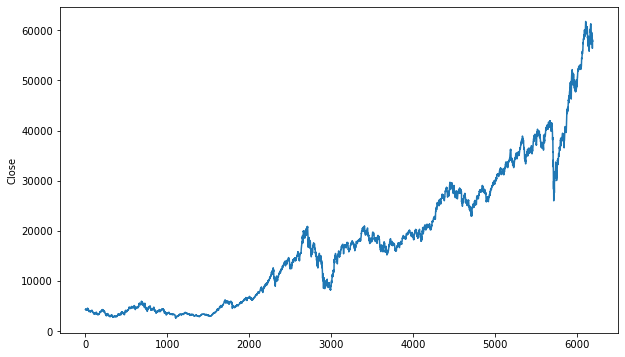

In [3]:
df_prices.dropna(inplace = True)
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

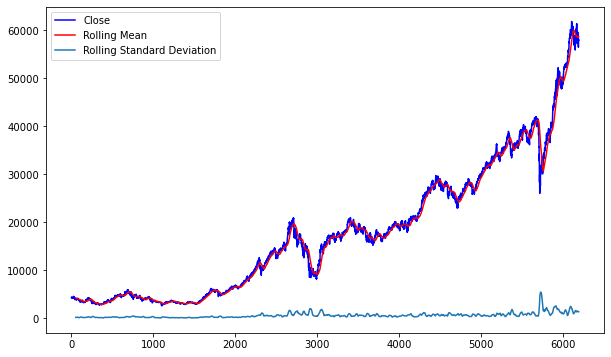

In [4]:
#Plotting moving average

close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()


Text(0.5, 1.0, 'Returns')

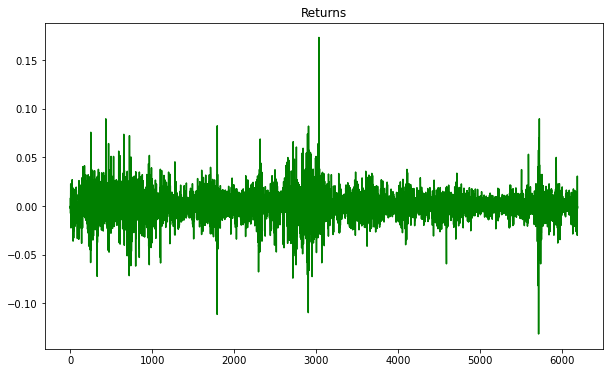

In [5]:
#Plotting returns

returns = close / close.shift(1) - 1
plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

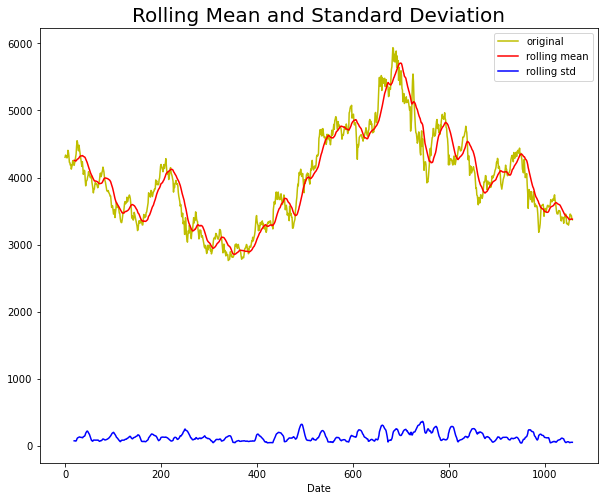

Results of dickey fuller test
ADF Test Statistic : -1.8735252065073
p-value : 0.34461632467262715
#Lags Used : 9
Number of Observations Used : 990
Weak evidence against null hypothesis, time series is non-stationary 


In [6]:
 #Determing rolling statistics
    
train = df_prices[:1000]
test = df_prices[1000:]

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()
    plt.figure(figsize = (10,8))
    plt.plot(timeseries, color = 'y', label = 'original')
    plt.plot(rolmean, color = 'r', label = 'rolling mean')
    plt.plot(rolstd, color = 'b', label = 'rolling std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
    plt.show(block = False)
    print('Results of dickey fuller test')
    result = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary ")

test_stationarity(train['Close'])

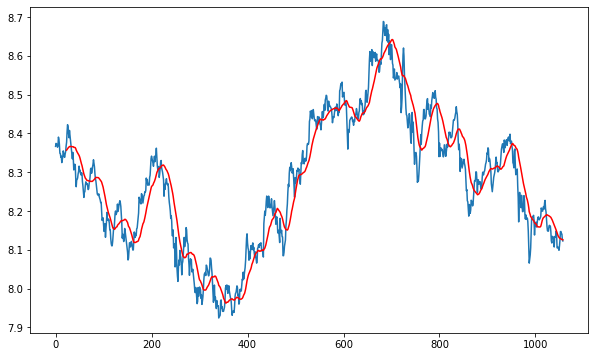

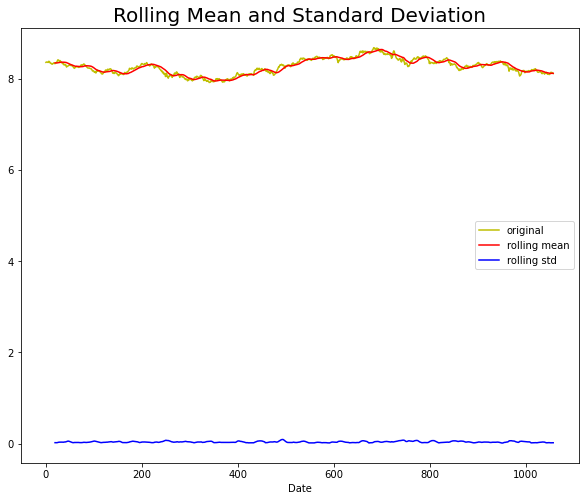

Results of dickey fuller test
ADF Test Statistic : -1.86716895086353
p-value : 0.3476599282722339
#Lags Used : 9
Number of Observations Used : 990
Weak evidence against null hypothesis, time series is non-stationary 


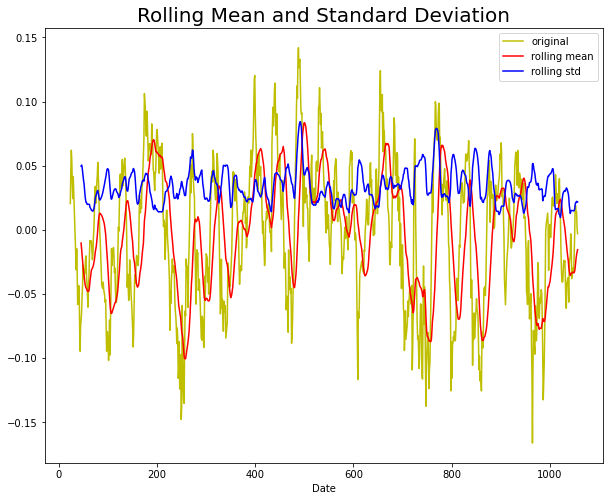

Results of dickey fuller test
ADF Test Statistic : -6.9721993525651556
p-value : 8.607477708608948e-10
#Lags Used : 9
Number of Observations Used : 967
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [7]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5096.664, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5099.231, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5099.479, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5098.497, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5098.059, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5098.045, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5096.154, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5101.333, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5099.908, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5099.892, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5101.085, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5098.003, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.016 seconds
RMSE :  1.75822

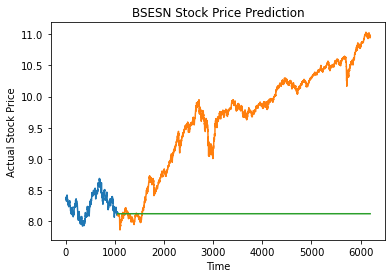

In [8]:
#Using auto arima to make predictions using log data

from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

In [9]:
# Textual Analysis

columns = ['Date','Category','News']
ndf = pd.read_csv('india-news-headlines.csv',names=columns)

In [10]:
print('Show part of the whole datase :')
ndf.head()

Show part of the whole datase :


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [11]:
ndf.drop(0, inplace = True)
ndf.drop('Category', axis = 1,inplace = True)
print('Showing part of the whole dataset :')
ndf.head(-5)

Showing part of the whole dataset :


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3424058,20201231,50 NRIs reach Singhu; offer help to farmers
3424059,20201231,Navjot Singh Sidhu tweets apology; says 'wore ...
3424060,20201231,Azim Premji organisation's name misused to che...
3424061,20201231,Get govt nod to probe officials: MP to agencies


In [12]:
# Check  for common information of the first dataset
ndf['Date'] = pd.to_datetime(ndf['Date'],format='%Y%m%d')
# Dataset information
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 78.4+ MB


In [13]:
# Group the headlines for eachday 
ndf['News'] = ndf.groupby(['Date']).transform(lambda x:' '.join(x))
ndf = ndf.drop_duplicates()
ndf.reset_index(inplace = True, drop = True)

In [14]:
df_news = ndf
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [16]:
#Functions to get the subjectivity and polarity

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [17]:
#Adding subjectivity and polarity columns

df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.395808,0.035886
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.424021,0.061210
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496


<AxesSubplot:>

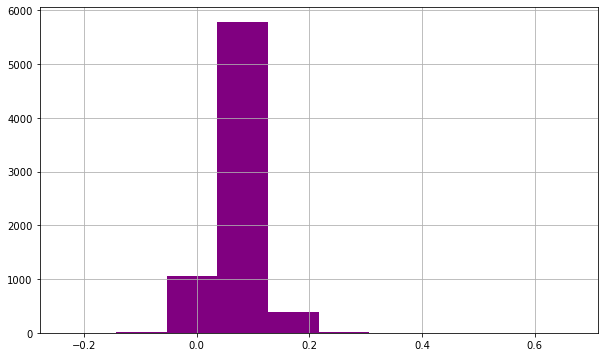

In [19]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

<AxesSubplot:>

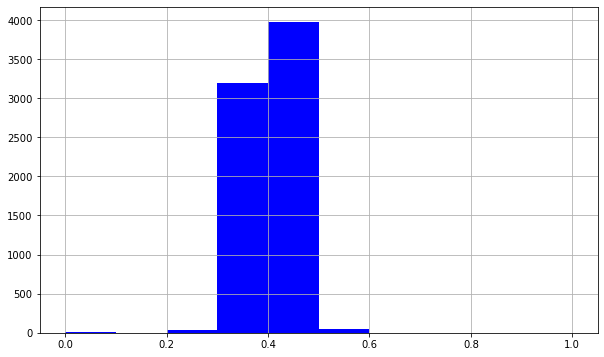

In [20]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [21]:
#Adding sentiment score to df_news

sia = SentimentIntensityAnalyzer()

In [22]:
df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]

In [23]:
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]

In [24]:
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]

In [25]:
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]

In [26]:
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024,0.9769,0.124,0.719,0.157
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.4215,0.152,0.704,0.143
...,...,...,...,...,...,...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.395808,0.035886,-0.9997,0.129,0.793,0.078
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517,-0.9998,0.138,0.768,0.093
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.424021,0.061210,-0.9999,0.150,0.754,0.096
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496,-0.9999,0.144,0.775,0.081


In [27]:
df_merge = pd.merge(df_prices, df_news, how = 'inner', on = 'Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0,Light combat craft takes India into club class...,0.476612,0.262024,0.9769,0.124,0.719,0.157
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0,Sangh Parivar; Babri panel up the ante Frontru...,0.414653,-0.019214,-0.9779,0.121,0.812,0.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,2020-12-24,46743.488281,47053.398438,46539.019531,46973.539063,46973.539063,13700.0,How to set the mood for sex during cold winter...,0.390942,0.048166,-0.9989,0.094,0.838,0.067
4894,2020-12-28,47153.589844,47406.718750,47148.238281,47353.750000,47353.750000,9600.0,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517,-0.9998,0.138,0.768,0.093
4895,2020-12-29,47466.621094,47714.550781,47361.898438,47613.078125,47613.078125,12800.0,Man recovers charred remains of 'thief' from h...,0.424021,0.061210,-0.9999,0.150,0.754,0.096
4896,2020-12-30,47789.031250,47807.851563,47358.359375,47746.218750,47746.218750,15600.0,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496,-0.9999,0.144,0.775,0.081


In [28]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,4018.879883,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,4060.020020,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,4115.370117,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,4183.729980,0.476612,0.262024,0.9769,0.124,0.719,0.157
4,4120.430176,0.414653,-0.019214,-0.9779,0.121,0.812,0.066
...,...,...,...,...,...,...,...
4893,46973.539063,0.390942,0.048166,-0.9989,0.094,0.838,0.067
4894,47353.750000,0.412945,0.070517,-0.9998,0.138,0.768,0.093
4895,47613.078125,0.424021,0.061210,-0.9999,0.150,0.754,0.096
4896,47746.218750,0.441660,0.043496,-0.9999,0.144,0.775,0.081


In [30]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.031422,0.282333,0.524545,0.00945,0.274775,0.807,0.116776
1,0.032334,0.407692,0.438811,0.36800,0.274775,0.766,0.182566
2,0.033559,0.446847,0.438129,0.93690,0.225225,0.797,0.169408
3,0.035073,0.476612,0.675488,0.98845,0.279279,0.719,0.258224
4,0.033672,0.414653,0.291981,0.01105,0.272523,0.812,0.108553


In [31]:
X = new_df.drop('Close', axis=1)
y = new_df['Close']
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.282333,0.524545,0.00945,0.274775,0.807,0.116776
1,0.407692,0.438811,0.36800,0.274775,0.766,0.182566
2,0.446847,0.438129,0.93690,0.225225,0.797,0.169408
3,0.476612,0.675488,0.98845,0.279279,0.719,0.258224
4,0.414653,0.291981,0.01105,0.272523,0.812,0.108553


In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
4685,0.399208,0.383325,0.00005,0.317568,0.792,0.110197
4589,0.395053,0.377636,0.00005,0.351351,0.767,0.128289
2700,0.427923,0.427909,0.00260,0.286036,0.752,0.199013
283,0.421922,0.443916,0.00390,0.310811,0.734,0.212171
1014,0.406182,0.346287,0.00400,0.306306,0.761,0.169408
2788,0.376364,0.402333,0.00005,0.353604,0.754,0.148026
446,0.430282,0.474949,0.02860,0.288288,0.740,0.217105
3319,0.400171,0.397764,0.00005,0.376126,0.726,0.175987
3822,0.380780,0.431231,0.00005,0.373874,0.729,0.172697
1262,0.401619,0.350531,0.01685,0.259009,0.781,0.171053


In [36]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction = rf.predict(x_test)
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction, y_test))

[0.32457505 0.10007292 0.16416222 0.42208689 0.48728237 0.26087876
 0.11332852 0.57674469 0.10856879 0.12082207]
2762    0.322269
42      0.026377
1419    0.228271
3664    0.514684
2125    0.302632
2154    0.297946
1457    0.237869
3957    0.585767
1248    0.163473
1013    0.095567
Name: Close, dtype: float64
0.02249945769970448


In [38]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.02867769199691197


In [39]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions, y_test))

[0.26706639 0.01525075 0.18031566 0.40824513 0.50998923 0.1536218
 0.08374703 0.63472786 0.06483636 0.01557322]
2762    0.322269
42      0.026377
1419    0.228271
3664    0.514684
2125    0.302632
2154    0.297946
1457    0.237869
3957    0.585767
1248    0.163473
1013    0.095567
Name: Close, dtype: float64
0.04270892110120543


In [40]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor()

In [41]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.022215780397437896


In [42]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [43]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.024519248434588792
